# Starbucks App Reward Program

**Author: Joel Ligma**            
<br>
**Date: May 2020 - July 2020**


**Context**
<br>

The goal of this project was to predict customer with a high likelihood of completing an offer. In the context of this project, completing an offer refers to a customer receiving a promotional offer, viewing the offer, and using it to complete a purchase. One of the main challenges of this project was to generate a single dataset derived from multiple dataset sources and to prepare the data for later analysis. The data files used for this project were sourced from Kaggle:
https://www.kaggle.com/blacktile/starbucks-app-customer-reward-program-data

## Table of Contents
**1) Data Preprocessing and Merging Multiple Datasets** 
- Data Cleaning
- Feature Engineering
- Merging/Concatenating/Joining
<br>

**2) Exploratory Data Analysis (EDA)**
- Summary Statistics
- Univariate Analysis
- Bivariate Analysis
<br>

**3) Data Preparation**
- Feature Correlation
- Dummy Coding
- Training, Validation and Test Split
- Scaling Data
<br>

**4) Model Building & Validation**
- Baseline Accuracy
- Random Forest Classifier
- Neural Network Classifier
- XGBoost Classifier
- Model Comparison
<br>

**5) Saving the Model**
- Saving the Best Performing Model for Future Deployment
<br>

**6) Conclusion**
- Business Implications and Recommendations

# 1) Data Preprocessing and Merging Multple Datasets

In [1]:
# load Modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MultiLabelBinarizer # awesome for multiple values in one cell
import csv # write csv file of the complete dataset
from datetime import date 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler # for scaling
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # model validation
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from sklearn.externals import joblib

C:\Users\joell\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
# load dataset
df = pd.read_csv("starbucks.csv")
df.drop(columns="Unnamed: 0", inplace=True)

# 3) Data Preparation

**Dummy Coding Features**

In [4]:
# dummy coding the Event feature
df_dummies = pd.get_dummies(df['event'])

# combine the df_dummies with the transcript dataframe
df = pd.concat([df, df_dummies], axis=1)

# rename columns to more suitable names
df.rename(columns = {4:'offer_completed', 
                     3:'offer_viewed',
                     2:'offer_received',
                     1:'transaction'
                     },inplace=True)

# let's drop transaction because this information is included in transaction_amount
df.drop(columns=["event","transaction"], inplace=True) 
df.head()

,transaction_amount,days_since_test,age,income,male,membership_days,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,offer_received,offer_viewed,offer_completed
0,0.0,2,45.0,62000.0,0.0,608.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0,0,1
1,0.0,18,71.0,56000.0,1.0,158.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0,1,0
2,0.0,8,71.0,73000.0,1.0,268.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0,0,1
3,0.0,0,69.0,83000.0,0.0,1040.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0,0,1
4,0.0,7,59.0,93000.0,0.0,329.0,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0,0,1


After examining the output depicted above, we can determine that the dummy-coding worked as intended. Dummy-codeing the **Event** feature resulted in 4 columns from which we dropped **Transaction** because whether or not a transaction was performed is known as soon as we have a value greater than 0 in **Transaction Amount**.

However, we could still use 3 out of these 4 columns to perfectly predict the 4th column:
- Transaction Amount
- Offer Completed
- Offer Viewed
- Offer Received

In other words, we now deal with the dummy trap problem which is undesirable for machine learning. Therefore, let's drop the **Offer Received** column to avoid this issue.

**Important Note:** Since machine learning projects are iterative projects, it was determined that keeping **Offer Viewed** over **Offer Received** will result in much higher predictive accuracy.

In [5]:
df.drop(columns="offer_received",inplace=True)

**Examine Feature Correlations**

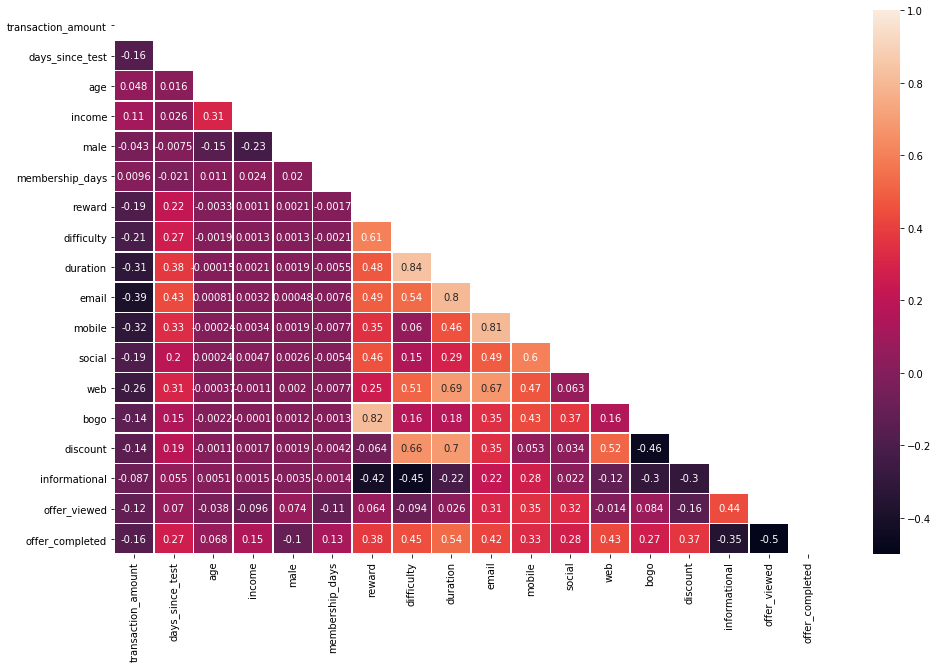

In [6]:
plt.figure(figsize=(16,10))
# Compute the correlation matrix
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# plot heatmap
sns.heatmap(df.corr(),yticklabels=True, annot=True,mask=mask,linewidths=.5)

We can see some relatively highly correlated variables (> 0.7). Let's drop **Duration** and **Difficulty**.

In [6]:
df.drop(columns="duration", inplace=True) 
df.drop(columns="difficulty", inplace=True) 

**Feature Correlation on Dependend Variable Offer Completed**

In [9]:
df.corr()["offer_completed"].sort_values()

offer_viewed         -0.499911
informational        -0.354199
transaction_amount   -0.163906
male                 -0.104208
age                   0.067917
membership_days       0.125625
income                0.151282
days_since_test       0.272021
bogo                  0.273163
social                0.277122
mobile                0.329895
discount              0.369564
reward                0.381698
email                 0.418454
web                   0.430898
offer_completed       1.000000
Name: offer_completed, dtype: float64

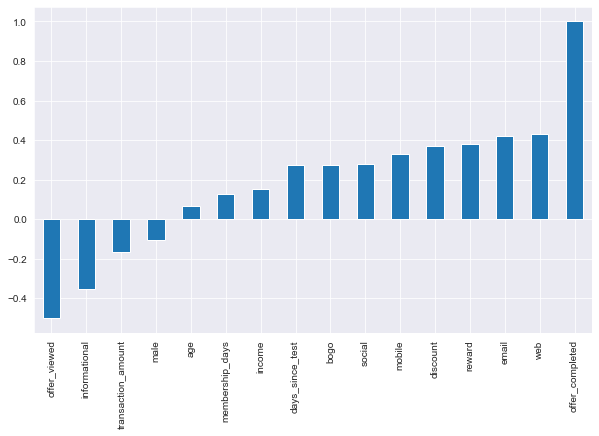

In [10]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
df.corr()["offer_completed"].sort_values().plot(kind="bar")

We ignore **Offer Completed** in the plot presented above since it goes without saying that it has 100% correlation with itself. It looks like **web**, **email**, **reward** and **discount** have a moderately positive correlation with the response variable. On the other hand, **informational** and **offer viewed** show a moderately negative correlation with the outcome.

**Create Training, Validation and Test Split**

In [7]:
# Split the data into training, validation and test datasets 
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_test = train_test_split(df_train, test_size=0.2, random_state=1)

# separate the DV from the train/validation/test sets
X_train = df_train.drop(['offer_completed'], axis=1)
y_train = df_train.offer_completed.values
X_valid = df_valid.drop(['offer_completed'], axis=1)
y_valid = df_valid.offer_completed.values
X_test = df_test.drop(['offer_completed'], axis=1)
y_test = df_test.offer_completed.values

**Feature Scaling**

In [8]:
# Since we have many different types of features in our dataset e.g. age, income etc. we should normalize the data

# create an instance of MinMaxScaler
scaler = MinMaxScaler().fit(X_train)

# now perform the transformations on the training, validation and test set
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

print("Training Data:", X_train.shape, y_train.shape,"\nValidation Data:", X_valid.shape, y_valid.shape,
      "\nTest Data:", X_test.shape, y_test.shape)

Training Data: (43993, 15) (43993,) 
Validation Data: (13749, 15) (13749,) 
Test Data: (10999, 15) (10999,)


# 4) Model Building and Validation

**Baseline Accuracy to Beat**

Let's take a naive approach as a baseline accuracy value to beat for all predictive models. Let's follow a "most frequent” approach. This approach looks at our response variable and always predicts the most frequent label. For our our response variable that would be:


In [11]:
print("Accuracy if we assume no customers complete an offer: {}%".format(round((df["offer_completed"]==0).sum() / len(df)*100,2)))

Accuracy if we assume no customers complete an offer: 59.98%


## Model 1: Random Forest

**Training the model**

In [11]:
# build RandomForestClassifier instance and fit on training data
rfc = RandomForestClassifier() # use default parameters first
rfc.fit(X_train, y_train)

#Addressing class imbalance by setting an inverse weight ratio
#class_weight = {0: sum(y_train==1) / len(y_train), 1: sum(y_train==0) / len(y_train)}
#class_weight

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

**Validating the Model's Performance**

In [12]:
# predict on the validation set
y_pred = rfc.predict(X_valid)
print("Confusion Matrix\n {}".format(confusion_matrix(y_valid, y_pred)))
print("\nValidation Accuracy: {:.2f}%\n \n".format(accuracy_score(y_valid, y_pred)*100))

Confusion Matrix
 [[7744  459]
 [ 202 5344]]

Validation Accuracy: 95.19%
 



95.19% accuracy is already pretty high. We already beat the baseline accuracy goal by just taking the default model parameters.

#### Random Forest: Tuning Model Hyperparameters with Grid Search

**Training the Model**

Let's see if we can improve our results.

In [100]:
# Create arbitary parameter grid for random search (keeping them modest due to low computational power)
param_grid = {'bootstrap'        : [True],
              'max_depth'        : [3, 5, 7, 10, 15],
              'max_features'     : [5, 10, 13, 14, 15],
             'min_samples_leaf'  : [3, 4, 5, 6, 7, 9],
              'min_samples_split': [2, 3,4, 5, 7],
              'n_estimators'     : [100, 150, 300]
             }

# Create the base model
rf = RandomForestClassifier()

# Create the grid search 
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, verbose = 2, n_jobs=-1, return_train_score=True)

In [101]:
# fit grid search on the training data
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 2250 candidates, totalling 6750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 33.2min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 46.3min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 57.9min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 75.0min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed: 90.6min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed: 129.4min
[Parallel(n_jobs=-1)]: Done 6750 out of 6750 | elapsed: 151.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [102]:
# get best parameters from grid search
grid_search_rf.best_params_ 

{'bootstrap': True,
 'max_depth': 15,
 'max_features': 15,
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 300}

**Validating Our Model**

In [103]:
# define the best model parameters 
best_grid = grid_search_rf.best_estimator_

# predict on validation data with best parameters
y_pred1 = best_grid.predict(X_valid)

# show confusion matrix and accuracy
print("Confusion Matrix\n {}".format(confusion_matrix(y_valid, y_pred1)))
print("\nValidation Accuracy: {:.2f}%\n \n".format(accuracy_score(y_valid, y_pred1)*100))

Confusion Matrix
 [[7875  328]
 [ 187 5359]]

Validation Accuracy: 96.25%
 



Once we are content with our validation accuracy we can use our model to predict the test data.

**Using the Model to Predict Test Data**

In [104]:
# make predictions on test data  
y_pred2 = best_grid.predict(X_test)

# get confusion matrix, test accuracy
print("Confusion Matrix\n {}".format(confusion_matrix(y_test, y_pred2)))
print("\nTest Accuracy: {:.2f}%\n \n".format(accuracy_score(y_test, y_pred2)*100))

# get classification report
print(classification_report(y_test, y_pred2))

Confusion Matrix
 [[6306  254]
 [ 165 4274]]

Test Accuracy: 96.19%
 

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      6560
           1       0.94      0.96      0.95      4439

    accuracy                           0.96     10999
   macro avg       0.96      0.96      0.96     10999
weighted avg       0.96      0.96      0.96     10999



The final test accuracy equals 96.24%.

## Model 2: Neural Network Classifier

**Training and Validating the Model**

- Defining our model by creating a Sequential model and adding layers
- Compiling our model by specifing the loss function and optimizer

In [25]:
# create the nn model
nn = keras.Sequential()
nn.add(Dense(units=15,activation="relu"))
nn.add(Dropout(0.5))
nn.add(Dense(units=8,activation="relu"))
nn.add(Dropout(0.5))
nn.add(Dense(units=4,activation="relu"))
nn.add(Dropout(0.5))
# binary classification so we choose sigmoid activation function
nn.add(Dense(units=1,activation="sigmoid")) # one output unit because we deal with binary classification
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

In [26]:
# fit the model on the training data 
history = nn.fit(X_train, y_train, epochs = 100, batch_size=32, validation_data=(X_valid, y_valid), workers=-1).history

Epoch 1/100
1375/1375 [==============================] - 1s 849us/step - loss: 0.5998 - accuracy: 0.6645 - val_loss: 0.2672 - val_accuracy: 0.9225
Epoch 2/100
1375/1375 [==============================] - 1s 807us/step - loss: 0.4079 - accuracy: 0.8039 - val_loss: 0.1724 - val_accuracy: 0.9284
Epoch 3/100
1375/1375 [==============================] - 1s 854us/step - loss: 0.3694 - accuracy: 0.8212 - val_loss: 0.1650 - val_accuracy: 0.9297
Epoch 4/100
1375/1375 [==============================] - 1s 825us/step - loss: 0.3542 - accuracy: 0.8277 - val_loss: 0.1562 - val_accuracy: 0.9318
Epoch 5/100
1375/1375 [==============================] - 1s 806us/step - loss: 0.3440 - accuracy: 0.8348 - val_loss: 0.1570 - val_accuracy: 0.9356
Epoch 6/100
1375/1375 [==============================] - 1s 851us/step - loss: 0.3383 - accuracy: 0.8400 - val_loss: 0.1554 - val_accuracy: 0.9390
Epoch 7/100
1375/1375 [==============================] - 1s 816us/step - loss: 0.3418 - accuracy: 0.8349 - val_loss: 0

In [45]:
print("Neural Network Classifier average validation accuracy: {}".format(losses["val_accuracy"].mean()))


Neural Network Classifier average validation accuracy: 0.9373714482784271


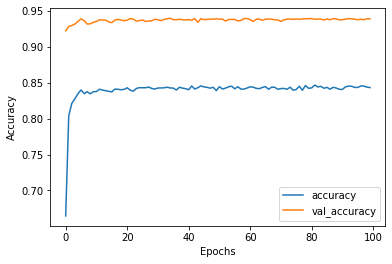

In [37]:
losses = pd.DataFrame(nn.history.history)
losses["accuracy"].plot()
losses["val_accuracy"].plot()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

The neural network classifier shows an average validation accuracy of around 93.74%. We can also see that the accuracy value stagnated after around 5-10 epochs. Consequently, it is slightly worse than the Random Forest model. However, we simply used the default parameters thus far. Let's try to improve the accuracy.

#### Neural Network Classifier: Tuning Model Hyperparameters with Grid Search

**Training the Model**

Let's see if we can improve our results.

- Defining our model by creating a Sequential model and adding layers
- Compiling our model by specifing the loss function and optimizer

In [ ]:
# create the nn model
def build_model(lr=0.01):
    '''
    This function builds a neural network classifier.
    '''
    nn = Sequential()
    nn.add(Dense(units=15,activation="relu")) # 17 because 17 input features
    nn.add(Dropout(0.5))
    nn.add(Dense(units=8,activation="relu"))
    nn.add(Dropout(0.5))
    nn.add(Dense(units=4,activation="relu"))
    nn.add(Dropout(0.5))
    # binary classification so we choose sigmoid activation function
    nn.add(Dense(units=1,activation="sigmoid")) # one output unit because we deal with binary classification
    # set optimizer
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    nn.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    
    return nn

In [ ]:
# Create the actual model
model = KerasClassifier(build_fn=build_model, batch_size=32, epochs=10)

In [69]:
# Create arbitary parameter grid for random search (keeping them modest due to low computational power)
batch_size = [16, 32, 64]
epochs = [100, 200]
learn_rate = [0.0001, 0.001, 0.01, 0.1]

# create the parameter grid
param_grid = dict(lr=learn_rate, batch_size=batch_size,epochs=epochs)

# build the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=10, return_train_score=True)

In [70]:
# fit grid search on the training data
grid_results = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed: 28.1min
[Parallel(n_jobs=10)]: Done  72 out of  72 | elapsed: 52.9min finished


Epoch 1/200
688/688 [==============================] - 1s 752us/step - loss: 0.5790 - accuracy: 0.6689
Epoch 2/200
688/688 [==============================] - 1s 755us/step - loss: 0.4042 - accuracy: 0.7925
Epoch 3/200
688/688 [==============================] - 1s 770us/step - loss: 0.3569 - accuracy: 0.8191
Epoch 4/200
688/688 [==============================] - 1s 1ms/step - loss: 0.3433 - accuracy: 0.8244
Epoch 5/200
688/688 [==============================] - 1s 839us/step - loss: 0.3401 - accuracy: 0.8270
Epoch 6/200
688/688 [==============================] - 1s 796us/step - loss: 0.3329 - accuracy: 0.8265
Epoch 7/200
688/688 [==============================] - 1s 797us/step - loss: 0.3315 - accuracy: 0.8292
Epoch 8/200
688/688 [==============================] - 1s 752us/step - loss: 0.3314 - accuracy: 0.8283
Epoch 9/200
688/688 [==============================] - 1s 796us/step - loss: 0.3262 - accuracy: 0.8322
Epoch 10/200
688/688 [==============================] - 1s 738us/step - los

688/688 [==============================] - 1s 771us/step - loss: 0.3178 - accuracy: 0.8405
Epoch 158/200
688/688 [==============================] - 1s 748us/step - loss: 0.3162 - accuracy: 0.8395
Epoch 159/200
688/688 [==============================] - 1s 736us/step - loss: 0.3201 - accuracy: 0.8345
Epoch 160/200
688/688 [==============================] - 1s 1ms/step - loss: 0.3145 - accuracy: 0.8376
Epoch 161/200
688/688 [==============================] - 1s 822us/step - loss: 0.3200 - accuracy: 0.8361
Epoch 162/200
688/688 [==============================] - 1s 783us/step - loss: 0.3196 - accuracy: 0.8361
Epoch 163/200
688/688 [==============================] - 1s 754us/step - loss: 0.3157 - accuracy: 0.8388
Epoch 164/200
688/688 [==============================] - 0s 719us/step - loss: 0.3173 - accuracy: 0.8385
Epoch 165/200
688/688 [==============================] - 1s 765us/step - loss: 0.3125 - accuracy: 0.8425
Epoch 166/200
688/688 [==============================] - 1s 774us/step 

In [71]:
# get best parameters from grid search
grid_results.best_params_

{'batch_size': 64, 'epochs': 200, 'lr': 0.001}

**Validating the Model's Performance**

In [72]:
# define the best model parameters 
best_grid = grid_results.best_estimator_

# predict on validation data with best parameters
y_pred3 = best_grid.predict(X_valid)

# show confusion matrix and accuracy
print("Confusion Matrix\n {}".format(confusion_matrix(y_valid, y_pred3)))
print("\nValidation Accuracy: {:.2f}%\n \n".format(accuracy_score(y_valid, y_pred3)*100))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Confusion Matrix
 [[7664  539]
 [ 283 5263]]

Validation Accuracy: 94.02%
 



Once we are content with our validation accuracy we can use our model to predict the test data.

**Using the Model to Predict Test Data**

In [77]:
# make predictions on test data  
y_pred4 = best_grid.predict(X_test)

# get confusion matrix, test accuracy
print("Confusion Matrix\n {}".format(confusion_matrix(y_test, y_pred4)))
print("\nTest Accuracy: {:.2f}%\n \n".format(accuracy_score(y_test, y_pred4)*100))

# get classification report
print(classification_report(y_test, y_pred4))

Confusion Matrix
 [[6150  410]
 [ 246 4193]]

Test Accuracy: 94.04%
 

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      6560
           1       0.91      0.94      0.93      4439

    accuracy                           0.94     10999
   macro avg       0.94      0.94      0.94     10999
weighted avg       0.94      0.94      0.94     10999



## Model 3: XGBoost
<br>

XGBoost or eXtreme Gradient Boosting is an advanced implementation of the gradient boosting algorithm.
XGBoost is a great choice here because the dataset is quite large with initially 68,741 observations. This is because it is very computationally efficient and typically yields very high accuracy.

**Training The Model**

In [78]:
# set up the classifier. Once again we will use the default parameters as starting point
xgbc = XGBClassifier()

# fit the model on the training set
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

**Validating the Model's Performance**

In [79]:
# predict validation data
y_pred5 = xgbc.predict(X_valid)

# show model performance on test data
print("Confusion Matrix\n {}".format(confusion_matrix(y_valid, y_pred5)))
print("Validation Accuracy: {:.2f}%".format(accuracy_score(y_valid, y_pred5)*100))

Confusion Matrix
 [[7904  299]
 [ 202 5344]]
Validation Accuracy: 96.36%


As expected, even with default parameters XGBoost yields very high predictive accuracy. In fact, it already shows the highest accuracy among the 3 predictive models without parameter tuning.

#### XGBoost Classifier: Tuning Model Hyperparameters with Grid Search

Here we will tune some of the hyperparameters to boost the model's performance. It won't find the optimal solution, but a solution that is sufficient considering the limited resources available.

**Training The Model**

In [19]:
# define the classifier
xgbc = XGBClassifier()

# defining parameter grid for XGBoost
parameters = {"eta"                  : [0.01, 0.1, 0.2],
              "max_depth"            : [1,2,3, 4, 5,],
           #  "min_child_weight"     : [1,2,5,10,20,30],
              "colsample_bytree"     : [0.5, 0.6, 0.9],
            #  "subsample"            : [0.5, 0.9, 1.0], # subsample ratio of the training instances, prevents overfitting
              "n_estimators"         : [50,100,150,200]
             }

# setting up the random grid search
grid_search_xgb = GridSearchCV(estimator = xgbc, param_grid = parameters, cv=3, verbose=2, n_jobs=-1, return_train_score=True)
# fit grid search on the training data
grid_results = grid_search_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 3600 candidates, totalling 10800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed: 34.0min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed: 41.6min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed: 49.0min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed: 59.8min
[Parallel(n_jobs=-1)]: Done 9089 tasks      | 

In [16]:
grid_results.best_params_
#'colsample_bytree': 0.5, 'eta': 0.2, 'max_depth': 4, 'n_estimators': 100}  96.61% 

{'colsample_bytree': 0.5, 'eta': 0.2, 'max_depth': 4, 'n_estimators': 100}

In [17]:
# predict validation data
y_pred5 = grid_results.predict(X_valid)

# show model performance on test data
print("Confusion Matrix\n {}".format(confusion_matrix(y_valid, y_pred5)))
print("Validation Accuracy: {:.2f}%".format(accuracy_score(y_valid, y_pred5)*100))

Confusion Matrix
 [[7913  290]
 [ 176 5370]]
Validation Accuracy: 96.61%


**Using the Model to Predict Test Data**

In [24]:
# let's use the trained XBG model to predict the test data 
y_pred9 = grid_results.predict(X_test)

# show model performance on test data
print("Confusion Matrix\n {}".format(confusion_matrix(y_test, y_pred9)))
print("\nTest Accuracy: {:.2f}%\n \n".format(accuracy_score(y_test, y_pred9)*100))

# get classification report
print(classification_report(y_test, y_pred9))

Confusion Matrix
 [[6337  223]
 [ 161 4278]]

Test Accuracy: 96.51%
 

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      6560
           1       0.95      0.96      0.96      4439

    accuracy                           0.97     10999
   macro avg       0.96      0.96      0.96     10999
weighted avg       0.97      0.97      0.97     10999



## Model Comparison

In [25]:
print("Random Forest\nValidation Accuracy:{}% \nTest Accuracy: {}%".format(96.25, 96.19))
print("\nNeural Network\nValidation Accuracy: {}%\nTest Accuracy: {}%".format(94.02, 94.04))
print("\nXGBoost\nValidation Accuracy: {}%\nTest Accuracy: {}%\n".format(96.61, 96.51))

Random Forest
Validation Accuracy:96.25% 
Test Accuracy: 96.19%

Neural Network
Validation Accuracy: 94.02%
Test Accuracy: 94.04%

XGBoost
Validation Accuracy: 96.61%
Test Accuracy: 96.51%



It goes without saying that there is still room for improvement which could be achieved through e.g. the usage of increased computational power and more time for the model training process. For instance, 3-Fold CV was chosen to save time during the training process which could be increased to 5 or 10-fold CV for better model generalization. Further, with more computational power, the neural network classifier could be trained again and will certainly yield much better results. Nonetheless, a test accuracy of 96.51% is decent.

# 5) Saving the Best Performing Model: XGBoost

In [26]:
# Save to file to working directory
joblib_file = "joblib_final_model.pkl"
joblib.dump(grid_results, joblib_file)

['joblib_final_model.pkl']

In [27]:
# Load from file
final_model = joblib.load("joblib_final_model.pkl")

In [28]:
# Calculate the accuracy and predictions
score = final_model.score(X_test, y_test)
print("Test Accuracy: {0:.2f} %".format(100 * score))

Test Accuracy: 96.51 %


**Successfully saved the final model. It is now ready for deployment.** 

# 6) Conclusion

In summary, the data analysis findings and the development of the classification prediction model, aiming to accurately predict customers with a high likelihood of completing an offer, resulted in the following insights described below.

**Demographics**
- Most customers are roughly aged between 40 and 75 years with an average age of around 54 years
- 41.9% female and 58.1% male customers 
- Average customer income equals 65,388.01 US dollars
- Only 40.02% of customers did complete an offer in the past
- Average income of customers who did complete an offer in the past: 69,398.28 US dollars (vs. 62,711.8 US dollars of those who did not)
- Average age of customers who did complete an offer in the past: 55.8 years (vs. 53.37 years of those who did not)
- The proportion of female customers who completed an offer is higher than male customers (46.04% vs. 35.69%)


Based on these findings, women tend to react more positively towards the promotions than men. Despite the fact that women only make up around 40% of the customers in the dataset provided, they almost contribute the same number of **completed offers** than men. (13,260 women vs. 14.254 men).

**Offers**
- Customers who received **Discount**: 31.74%
- Customers who received **BOGO**: 31.65%
- Customers who didn't receive an offer: 20.79%
- Customers who received **Informational**: 15.82%

- The offer type with the highest success rate is **Discount** (66.58%), followed by **BOGO** (59.69%)
- **Informational** offers can not be traced to any sales

Generally, **discounts** show the highest success rate among the 3 offer types and are also the most frequent promotion sent to customers. Furthermore, out of all offers sent out to customers, **informational** promotions make up approx. 15% of offers. 20.79% of customers did not receive any promotion. 

In terms of difficulty and duration, one can infer that a difficulty level of 10 USD leads to the most completed offers, followed by a level of 5 USD. Further, most offers were completed for promotions that were only valid for 7 days, followed by 10 days and 5 days respectively. No offers were completed for offers that are only valid for 3 or 4 days.

**Contact Methods**

When comparing the 4 contact methods used (email, mobile, social, web), most customers were contacted via email and mobile device. However, both of these contact methods showed a lower success rate of customers completing an offer compared to social media and web. 

- Customers contacted via email: 79.21%
- Customers contacted via mobile device: 71.2%
- Customers contacted via web: 63.33%
- Customers contacted via social media: 47.48%


- Web success rate: 56.09%
- Social media success rate: 54.31%
- Email success rate: 50.53%
- Mobile success rate: 50.3%

**Predictive Model**

We built and tuned 3 classifiaction prediction models with the goal to accurately predict our target customers. Our target customer sare defined as customers who have a high likelihood of completing an offer. The 3 models are Random Forest, Neural Network and eXtreme Gradient Boosting (XGBoost). After training and validating the model performance the following results were geneated:

- The Random Forest Classifier showed a predictive accuracy of 96.19%
- The Neural Network Classifier showed a predictive accuracy of 94.04%
- The **XBGoost** Classifier showed a predictive accuracy of **96.51%** 

Based on these results, we selected XGBoost as the final classifiaction prediction model with which we managed to predict our target customers with approximately 88.65% accuracy.

### Recommendations

In order to increase the company's marketing strategy effectiveness, we derived the following 3 recommendations based on the analysis findings above.

**1) Predicting Target Customers**
- Identify target customers using the XGBoost model

**2) Choosing the right Contact Method(s)**

Increase the usage of the following communication channel(s) to send offers:
- Web (because it showed the highest success rate among the 4 contact methods)
- Social media (because it showed the second highest success rate among the 4 contact methods)

**3) Customizing the Offer Appropriately**
- Send out more discounts beacuse they show the highest success rate
- Keep the amount of BOGO the same beacuse they still show a decent success rate
- Tailor the period an offer is valid around 7 - 10 days because this period showed the highest completed offers
- Avoid making offers valid for only 3 - 4 days because these offers didn't result in any completed offers

The goal is to decrease the total number of customers who did not receive an offer (20.79%) and to increase the success rate of offers sent out (currently 40.02%). This can be done by increasingly targeting female customers who match the target customer profile of customers with slightly above average income (69,398.28 US dollars) and age (55.8 years).

Following these recommendations will ensure a more efficient allocation of resources, an increase in the marketing success rate and ultimately growth in profitability for the organization.